# Sentiment Analysis Using Various Approaches

In [1]:
import numpy as np 
import pandas as pd
import json
import time
import re
import seaborn as sns

# Text cleaning
from nltk import sent_tokenize, word_tokenize, regexp_tokenize
from nltk.stem import WordNetLemmatizer
import spacy 
nlp = spacy.load('en_core_web_sm')

# NLTK Bing Liu Lexicon 
import nltk
# nltk.download('opinion_lexicon')
from nltk.corpus import opinion_lexicon
from nltk.tokenize import word_tokenize 

# VADER 
import nltk
# nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.metrics import accuracy_score, confusion_matrix

# Supervised learning 
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, roc_curve
from sklearn.calibration import CalibrationDisplay
import matplotlib.pyplot as plt
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline 
from sklearn.svm import LinearSVC

from scipy.sparse import csr_matrix
from scipy.sparse import hstack, vstack

from sklearn.dummy import DummyClassifier
from sklearn.feature_extraction.text import TfidfVectorizer

## Loading reviews and meta data

In [3]:
merge_df = pd.read_csv('../data/merge_df_select.csv', index_col = False)
# Remove null values in 'text' column 
merge_df = merge_df.dropna(subset=['text'])
# Remove rows where 'text' column contains empty strings
merge_df = merge_df[merge_df['text'].str.strip() != '']
# Reset the index of the DataFrame
merge_df.reset_index(drop=True, inplace=True)

print(f'Number of records: {len(merge_df)}')

C:\Users\MJ\AppData\Local\Temp\ipykernel_5712\3885783524.py:1: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  merge_df = pd.read_csv('../data/merge_df_select.csv', index_col = False)


Number of records: 2553766


## Feature Engineering 

Create new features: word count, average word length, exclamation mark count, and sentiment.

In [8]:
def word_count(text):
    """
    Counts the number of words in the text.
    """
    words = text.split()
    return len(words)


def avg_word_length(text):
    """
    Returns the average word length in the text. 
    """
    # Check for empty or white-space only string 
    if not text.strip():
        return 0
        
    words = text.split()
    if not words:  # Check if words list is empty
        return 0
        
    word_lengths = [len(word) for word in words]
    avg_word_length = sum(word_lengths)/len(words)
    
    return(avg_word_length) 


def exclamation_count(text):
    """
    Returns the number of exclamations in the text.
    """
    doc = nlp(text)
    exclamations = []
    for token in doc: 
        if token.text == '!':
            exclamations.append(token.text)
    return len(exclamations)

merge_df['word_count'] = merge_df['text'].apply(word_count)
merge_df['avg_word_length'] = merge_df['text'].apply(avg_word_length)
merge_df['exclamation_count'] = merge_df['text'].apply(exclamation_count)

In [9]:
merge_df['word_count'] = merge_df['text'].apply(word_count)
merge_df['avg_word_length'] = merge_df['text'].apply(avg_word_length)
merge_df['exclamation_count'] = merge_df['text'].apply(exclamation_count)

In [10]:
merge_df[['text', 'word_count', 'avg_word_length', 'exclamation_count']].head(3)

,text,word_count,avg_word_length,exclamation_count
0,Not gonna lie- they are not much to look at. L...,337,4.124629,1
1,I love it. Pretty!,4,3.750000,1
2,Huge fan of B Vertigo and this dressage pad do...,28,4.535714,1


In [11]:
merge_df['word_count'].describe()

count    9958.000000
mean       64.350171
std        94.064482
min         1.000000
25%        12.000000
50%        33.000000
75%        79.000000
max      1182.000000
Name: word_count, dtype: float64

C:\Users\MJ\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


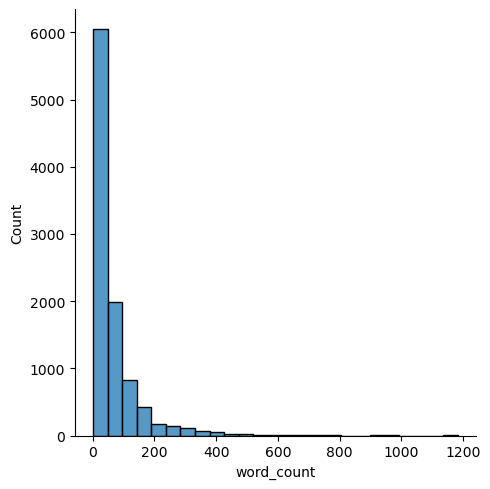

In [12]:
sns.displot(merge_df['word_count'],bins=25);

C:\Users\MJ\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


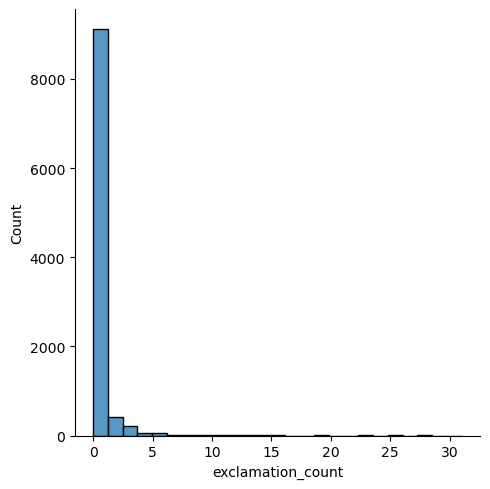

In [13]:
sns.displot(merge_df['exclamation_count'],bins=25);

## Sentiment Analysis with Lexicons

Unsupervised learning approach that involves evaluating the sentiment scores of words in a document based on predefined lexicons. A lexicon is a dictionary that contains a collection of words that is categorized as positive, negative, and neutral by experts. Each word's sentiment is determined, and the scores are combined to calculate the overall sentiment of the sentence. 
- Disadvantages: words that are not in the lexicon will not be scored; some lexicons might be better suited for a specific use; it overlooks negation (lexicons only match words and not phrases, ie "not bad" is scored more negative instead of neutral)

### Bing Liu Lexicon

The Bing Liu lexicon has a total of 6, 786 words with 2,005 classified as positive and 4,781 as negative. CLassification is binary (positive or negative).

In [4]:
print('Total number of words in opinion lexicon', len(opinion_lexicon.words()))
print('Examples of positive words:', opinion_lexicon.positive()[:10])
print('Examples of negative words:', opinion_lexicon.negative()[:10])

Total number of words in opinion lexicon 6789
Examples of positive words: ['a+', 'abound', 'abounds', 'abundance', 'abundant', 'accessable', 'accessible', 'acclaim', 'acclaimed', 'acclamation']
Examples of negative words: ['2-faced', '2-faces', 'abnormal', 'abolish', 'abominable', 'abominably', 'abominate', 'abomination', 'abort', 'aborted']


## Work with a subset

In [7]:
df_sample = merge_df.sample(n=100000, random_state=42)

In [8]:
pos_score = 1
neg_score = -1
word_dict = {}

# Adding the positive words to the dictionary
for word in opinion_lexicon.positive():
    word_dict[word] = pos_score 

# Adding the negative words to the dictionary 
for word in opinion_lexicon.negative():
    word_dict[word] = neg_score 

def bing_liu_score(text):
    sentiment_score = 0 
    bag_of_words = word_tokenize(text.lower())

    # Check if bag_of_words is empty
    if bag_of_words: 
        for word in bag_of_words: 
            if word in word_dict: 
                sentiment_score += word_dict[word]
        return sentiment_score / len(bag_of_words)
    else: 
        return 0

df_sample['Bing_Liu_score'] = df_sample['text'].apply(bing_liu_score)

### VADER Lexicon
Rule-based lexicon. 
9,000 features with scales of [-4] Extremely Negative to [4] Extremely Positive with [0] for Neutral or Neither. 

In [9]:
model = SentimentIntensityAnalyzer()

In [10]:
def vader_score(text):
    score = model.polarity_scores(text)
    compound_score = score['compound']
    return compound_score

df_sample['Vader_score'] = df_sample['text'].apply(vader_score)

### Lexicon Sentiment Accuracy Scores 

In [15]:
df_sample[['rating', 'text', 'Bing_Liu_score', 'Vader_score']].sample(3)

,rating,text,Bing_Liu_score,Vader_score
2542059,3,Before you purchase this product be advised th...,-0.031250,-0.3408
875396,5,Table is right height and solid for decent pla...,0.059701,0.9349
872380,4,So far these work! I feel like I go through a ...,0.076923,0.6996


In [19]:
random_row = df_sample.sample(2)
print(f'Rating: {random_row["rating"].iloc[0]}\n')
print(f'Text: {random_row["text"].iloc[0]}\n')
print(f'Bing Liu Score: {random_row["Bing_Liu_score"].iloc[0]}\n')
print(f'VADER Score: {random_row["Vader_score"].iloc[0]}\n')
print('----------')
print(f'Rating: {random_row["rating"].iloc[1]}\n')
print(f'Text: {random_row["text"].iloc[1]}\n')
print(f'Tokenized Sentences: {random_row["tokenized_sentences"].iloc[1]}\n')
print(f'Bing Liu Score: {random_row["Bing_Liu_score"].iloc[1]}\n')
print(f'VADER Score: {random_row["Vader_score"].iloc[1]}\n')

Rating: 5

Text: I used 1224 months for my baby 18 months! Fit perfect

Bing Liu Score: 0.08333333333333333

VADER Score: 0.7574

----------
Rating: 5

Text: This bolster is amazing. Its lightweight yet sturdy enough for my restorative and yin yoga practice. So grateful for choosing this one. Also the customer service amazing!!!

Tokenized Sentences: ['This bolster is amazing.', 'Its lightweight yet sturdy enough for my restorative and yin yoga practice.', 'So grateful for choosing this one.', 'Also the customer service amazing!!', '!']

Bing Liu Score: 0.18181818181818182

VADER Score: 0.9148



In [20]:
df_sample['rating'].value_counts()

rating
5    68555
4    14043
3     6925
1     6372
2     4105
Name: count, dtype: int64

In [13]:
# Calculate mean sentiment score for each rating category
mean_scores = df_sample.groupby('rating').agg({
    'Bing_Liu_score':'mean',
    'Vader_score': 'mean'
}).reset_index()

print(mean_scores)

   rating  Bing_Liu_score  Vader_score
0       1       -0.022785    -0.109003
1       2        0.001680     0.042641
2       3        0.027775     0.236261
3       4        0.088473     0.514890
4       5        0.141164     0.623261


## Supervised Learning Approach

Using supervised learning models, we will classify the sentiment of a review based on pre-processed text from spaCy. Reviews will be classified as positive or negative sentiment based on their ratings:
- Positive (1): records with ratings of 4 and 5.
- Negative (0): records with ratings of 1, 2, and 3. 

### Feature Engineering: Sentiment Classification
Create a new column in our dataset to classify records based on our ratings. 

In [21]:
df_sample['positive_rating'] = 0

# Classify records with rating higher than or equal to 4, positive (1)
df_sample.loc[df_sample['rating'] >= 4, 'positive_rating'] = 1

# Classify records with rating less than and equal to 3, negative (0)
df_sample.loc[df_sample['rating'] < 4 , 'positive_rating'] = 0

### Text Vectorization with TF-IDF
Use TF-IDF vectorizer to transform the text into vectors based on the frequency of words in the text:

In [22]:
tfidf = TfidfVectorizer()
clf = MultinomialNB()

pipe = Pipeline([("tfidf", tfidf), ("clf", clf)])

param_grid = {
    'tfidf__ngram_range':[(1,1), (1,2), (1,3)],
    'tfidf__min_df':[1, 2, 5, 10, 20],
    'clf__fit_prior':[False, True]
}

### Model training and Evaluation
The following models will be used in our analysis:
- Logistic Regression: a linear model for binary classification.
- Linear Support Vector Classification (SVC): A classifier that constructs a hyperplane to separate classes.
- Randomized Search Cross-Validation: A technique to tune hyperparameters for improving model performance.

#### Randomized Search Cross Validation

In [23]:
X = df_sample[['text']]
y = df_sample['positive_rating']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 42, stratify = y)

In [24]:
rs = RandomizedSearchCV(estimator = pipe, param_distributions = param_grid, verbose = 2, n_jobs = -1)
rs.fit(X_train['text'], y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


RandomizedSearchCV(estimator=Pipeline(steps=[('tfidf', TfidfVectorizer()),
                                             ('clf', MultinomialNB())]),
                   n_jobs=-1,
                   param_distributions={'clf__fit_prior': [False, True],
                                        'tfidf__min_df': [1, 2, 5, 10, 20],
                                        'tfidf__ngram_range': [(1, 1), (1, 2),
                                                               (1, 3)]},
                   verbose=2)

In [25]:
y_pred = rs.predict(X_test['text'])

print(f'Accuracy: {accuracy_score(y_test, y_pred)}')
print(f'ROC-AUC Score: {roc_auc_score(y_test, y_pred)}')
print(f'Classification Report: \n {classification_report(y_test,y_pred, zero_division = 0.0)}')
print(f'Confusion Matrix: \n {confusion_matrix(y_test, y_pred)}')

Accuracy: 0.8878
ROC-AUC Score: 0.6984539812418247
Classification Report: 
               precision    recall  f1-score   support

           0       0.89      0.41      0.56      3480
           1       0.89      0.99      0.94     16520

    accuracy                           0.89     20000
   macro avg       0.89      0.70      0.75     20000
weighted avg       0.89      0.89      0.87     20000

Confusion Matrix: 
 [[ 1420  2060]
 [  184 16336]]


In [26]:
# Finding the best parameters 
print(rs.best_params_)
print(rs.best_score_)

{'tfidf__ngram_range': (1, 3), 'tfidf__min_df': 10, 'clf__fit_prior': True}
0.8843250000000001


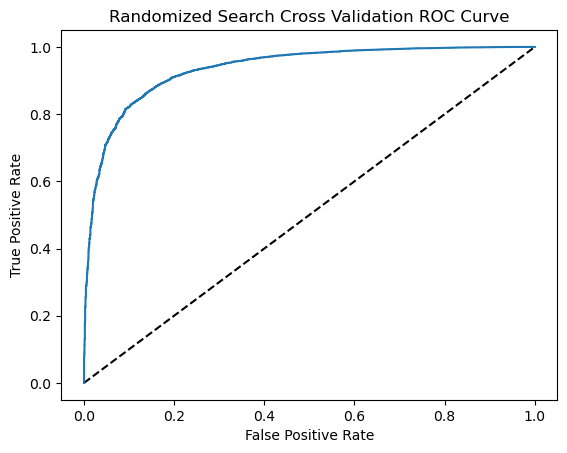

0.9354262771005538


In [27]:
sentiment_prob = rs.predict_proba(X_test['text'])
positive_class_prob = sentiment_prob[:, 1]

# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_test, positive_class_prob, pos_label=1)

# Plot ROC curve
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Randomized Search Cross Validation ROC Curve')
plt.show()

print(roc_auc_score(y_test, positive_class_prob))

#### Compare trained model to baseline 

In [28]:
dummy_clf = DummyClassifier(strategy = 'most_frequent')
dummy_clf.fit(X_train, y_train)
y_pred_baseline = dummy_clf.predict(X_test)

print(f'Accuracy: {accuracy_score(y_test, y_pred_baseline)}')
print(f'ROC-AUC Score: {roc_auc_score(y_test, y_pred_baseline)}')
print(f'Classification Report: \n {classification_report(y_test,y_pred_baseline, zero_division = 0.0)}')
print(f'Confusion Matrix: \n {confusion_matrix(y_test, y_pred_baseline)}')

Accuracy: 0.826
ROC-AUC Score: 0.5
Classification Report: 
               precision    recall  f1-score   support

           0       0.00      0.00      0.00      3480
           1       0.83      1.00      0.90     16520

    accuracy                           0.83     20000
   macro avg       0.41      0.50      0.45     20000
weighted avg       0.68      0.83      0.75     20000

Confusion Matrix: 
 [[    0  3480]
 [    0 16520]]


The trained randomized search cross validation model performs slightly beter than the baseline model.  

#### Linear Support Vector Classification (SVC)

In [29]:
tfidf = TfidfVectorizer(min_df = 5, ngram_range = (1,2))

X_train_tf = tfidf.fit_transform(X_train['text'])
X_test_tf = tfidf.transform(X_test['text'])

linear = LinearSVC(random_state = 42, tol = 1e-5, max_iter = 10000)
linear.fit(X_train_tf, y_train)

C:\Users\MJ\anaconda3\Lib\site-packages\sklearn\svm\_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


LinearSVC(max_iter=10000, random_state=42, tol=1e-05)

In [30]:
y_pred = linear.predict(X_test_tf)

print(f'Accuracy: {accuracy_score(y_test, y_pred)}')
print(f'ROC-AUC Score: {roc_auc_score(y_test, y_pred)}')
print(f'Classification Report: \n {classification_report(y_test,y_pred, zero_division = 0.0)}')
print(f'Confusion Matrix: \n {confusion_matrix(y_test, y_pred)}')

Accuracy: 0.91065
ROC-AUC Score: 0.8125417466811389
Classification Report: 
               precision    recall  f1-score   support

           0       0.79      0.66      0.72      3480
           1       0.93      0.96      0.95     16520

    accuracy                           0.91     20000
   macro avg       0.86      0.81      0.83     20000
weighted avg       0.91      0.91      0.91     20000

Confusion Matrix: 
 [[ 2304  1176]
 [  611 15909]]


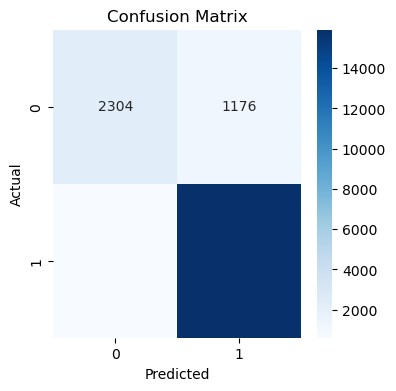

In [31]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(4, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

### Logistic Regression

In [32]:
tfidf_log = TfidfVectorizer(min_df = 10, ngram_range = (1,3))

X_train_tf = tfidf_log.fit_transform(X_train['text'])
X_test_tf = tfidf_log.transform(X_test['text'])

logreg = LogisticRegression(max_iter = 1000).fit(X_train_tf, y_train)

In [33]:
y_pred = logreg.predict(X_test_tf)

print(f'Accuracy: {accuracy_score(y_test, y_pred)}')
print(f'ROC-AUC Score: {roc_auc_score(y_test, y_pred)}')
print(f'Classification Report: \n {classification_report(y_test,y_pred, zero_division = 0.0)}')
print(f'Confusion Matrix: \n {confusion_matrix(y_test, y_pred)}')

Accuracy: 0.9079
ROC-AUC Score: 0.7777608471793159
Classification Report: 
               precision    recall  f1-score   support

           0       0.84      0.58      0.69      3480
           1       0.92      0.98      0.95     16520

    accuracy                           0.91     20000
   macro avg       0.88      0.78      0.82     20000
weighted avg       0.90      0.91      0.90     20000

Confusion Matrix: 
 [[ 2012  1468]
 [  374 16146]]


In [34]:
features = None
features = tfidf_log.get_feature_names_out(features)

sentiment = 0
idx = list(logreg.classes_).index(sentiment)


# # Extract coefficients from the Logistic Regression model 
intercept = logreg.intercept_[idx]
coefficients = logreg.coef_[idx]

coefficients_df = pd.DataFrame({
    'variable': ['intercept'] + list(features),
    'coefficient': [intercept] + list(coefficients)
})

coefficients_df.sort_values(by = 'coefficient', ascending = False)


,variable,coefficient
19802,great,12.960076
38690,perfect,8.408246
30492,love,8.214676
14328,easy,5.906681
33855,nice,5.626439
...,...,...
42014,return,-5.232209
57841,useless,-5.450733
8560,broke,-6.189501
13134,disappointed,-6.715607


In [ ]:
variables = ['helpful_vote', 'verified_purchase', 'word_count', 'avg_word_length', 
            'exclamation_count', 'text', 'Bing_Liu_score', 'Vader_score']
X_train[variables].astype(float)

In [ ]:
m = csr_matrix(X_train[variables].astype(float))
n = csr_matrix(X_test[variables].astype(float))

X_train_stack = hstack((m, X_train_tf))
X_test_stack = hstack((n, X_test_tf))

In [ ]:
linear.fit(X_train_stack, y_train)

y_pred = linear.predict(X_test_stack)

print(f'Accuracy: {accuracy_score(y_test, y_pred)}')
print(f'ROC-AUC Score: {roc_auc_score(y_test, y_pred)}')
print(f'Classification Report: \n {classification_report(y_test,y_pred, zero_division = 0.0)}')
print(f'Confusion Matrix: \n {confusion_matrix(y_test, y_pred)}')